In [110]:
import sys
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)

In [20]:
class DT_Classifier:
    def __init__(self, depth=10, features=7, criterion='gini'):
        self.model = None
        self.depth = depth
        self.features = features
        self.criterion = criterion

    def fit(self, x_train, y_train):
        if self.model == None:
            self.model = DecisionTreeClassifier(criterion=self.criterion, max_depth=self.depth, max_features=self.features)
        self.model = self.model.fit(x_train, y_train)

    def predict(self, x_test):
        if self.model == None:
            raise ValueError("Invalid model. Model has not been trained!")
        y_pred = self.model.predict(x_test)
        return y_pred

In [21]:
class DT_Regressor:
    def __init__(self, depth=10, features=7, criterion='squared_error'):
        self.model = None
        self.depth = depth
        self.features = features
        self.criterion = criterion

    def fit(self, x_train, y_train):
        if self.model == None:
            self.model = DecisionTreeRegressor(criterion=self.criterion, max_depth=self.depth, max_features=self.features)
        self.model = self.model.fit(x_train, y_train)

    def predict(self, x_test):
        if self.model == None:
            raise ValueError("Invalid model. Model has not been trained!")
        y_pred = self.model.predict(x_test)
        return y_pred

In [22]:
class LogisticRegression:
    def __init__(self, n, num, attr, learn_rate=0.001, n_epochs=100):
        self.n = n
        self.num = num
        self.attr = attr
        self.n_epochs = n_epochs
        self.learn_rate = learn_rate
        self.weights = np.zeros((attr, num))
        self.bias = np.zeros((1, num))

    # Loss function
    def cross_entropy_loss(self, y_true, y_pred, epsilon=1e-18):
        y_pred = np.clip(y_pred, epsilon, 1-epsilon)
        loss = -np.sum(y_true * np.log(y_pred+1e-9)) / self.n
        return loss
    
    # Gradient Descent step
    def gradient_descent(self, X, y_true, y_pred):
        error = y_pred - y_true
        dw = np.dot(X.T, error) / self.n
        db = np.sum(error) / self.n
        return dw, db

    # softmax activation function
    def softmax(self, X):
        e_x = np.exp(X - np.max(X, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)
    
    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(z)
        return y_pred
    
    def fit(self, X, Y):
        for _ in range(self.n_epochs):
            y_pred = self.predict(X)
            dw, db = self.gradient_descent(X, Y, y_pred)
            self.weights -= self.learn_rate*dw
            self.bias -= self.learn_rate*db

In [23]:
class LinearRegression:
    def __init__(self):
        self.theta = None

    def fit(self, X, Y):
        if isinstance(X, np.ndarray):
            X = np.insert(X, 0, 1, axis=1)
        elif 'const' not in X.columns:
            X.insert(0, 'const', 1)
        X_transpose = np.transpose(X)
        X_transpose_X_inv = np.linalg.inv(np.dot(X_transpose, X))
        self.coefficients = np.dot(np.dot(X_transpose_X_inv, X_transpose), Y)

    def predict(self, X):
        if isinstance(X, np.ndarray):
            X = np.insert(X, 0, 1, axis=1)
        elif 'const' not in X.columns:
            X.insert(0, 'const', 1)
        return np.dot(X, self.coefficients)

In [24]:
class MLP_Classifier:
    def __init__(self, layers, activation, learn_rate=0.01, n_epochs=1000):
        self.weights = []
        self.bias = []
        self.num = len(layers)-1
        self.batch_size = 32
        self.layers = layers
        self.func = activation
        self.rate = learn_rate
        self.n_epochs = n_epochs
        
        for i in range(len(layers)-1):
            w = np.random.rand(layers[i], layers[i+1])
            self.weights.append(w / np.sqrt(layers[i]))
            self.bias.append(np.zeros((1, layers[i+1])))

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def activation(self, x):
        if self.func == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        if self.func == 'tanh':
            return np.tanh(x)
        if self.func == 'ReLU':
            return np.maximum(0, x)
        
    def activation_gradient(self, x):
        if self.func == 'sigmoid':
            return np.exp(-x) / ((1 + np.exp(-x))**2)
        if self.func == 'tanh':
            return 1 - np.tanh(x)**2
        if self.func == 'ReLU':
            return np.where(x > 0, 1, 0)
        
    def batch(self, X, Y):
        n = self.batch_size
        for idx in range(0, len(X), n):
            yield X[idx:min(idx+n, len(X))], Y[idx:min(idx+n, len(X))]
        
    def fit(self, x_train, y_train):
        for _ in range(self.n_epochs):
            for (x_batch, y_batch) in self.batch(x_train, y_train):
                self.fit_instant(x_batch, y_batch)

    def fit_instant(self, x, y):
        # forward pass
        y_pred, z_pred = [x], [np.zeros_like(x)]
        for layer in range(self.num):
            z = np.dot(y_pred[layer], self.weights[layer]) + self.bias[layer]
            if layer==self.num-1: y_pred.append(self.softmax(z))
            else: y_pred.append(self.activation(z))
            z_pred.append(z)

        # backward pass
        error = y_pred[-1]-y
        derivatives = [error]
        for layer in range(self.num-1, 0, -1):
            delta = np.dot(derivatives[-1], self.weights[layer].T)
            delta = delta * self.activation_gradient(z_pred[layer])
            derivatives.append(delta)

        # update the weights
        derivatives = derivatives[::-1]
        for layer in range(self.num):
            self.weights[layer] += -self.rate * np.dot(y_pred[layer].T, derivatives[layer])
            self.bias[layer] += -self.rate * np.sum(derivatives[layer], axis=0, keepdims=True)

    def calculate_loss(self, y_true, y_pred, epsilon=1e-12):
        n = y_true.shape[0]
        y_pred = np.clip(y_pred, epsilon, 1-epsilon)
        loss = -np.sum(y_true * np.log(y_pred+1e-9)) / n
        return loss
    
    def predict(self, x):
        values = [x]
        for layer in range(self.num):
            z = np.dot(values[layer], self.weights[layer]) + self.bias[layer]
            if layer==self.num-1: values.append(self.softmax(z))
            else: values.append(self.activation(z))
        return values[-1]

In [25]:
class MLP_Regressor:
    def __init__(self, layers, activation, learn_rate=0.001, n_epochs=1000):
        self.weights = []
        self.bias = []
        self.num = len(layers)-1
        self.batch_size = 1
        self.layers = layers
        self.func = activation
        self.rate = learn_rate
        self.n_epochs = n_epochs
        
        for i in range(len(layers)-1):
            w = np.random.rand(layers[i], layers[i+1])
            self.weights.append(w / np.sqrt(layers[i]))
            self.bias.append(np.zeros((1, layers[i+1])))
    
    def activation(self, x):
        if self.func == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        if self.func == 'tanh':
            return np.tanh(x)
        if self.func == 'ReLU':
            return np.maximum(0, x)
        
    def activation_gradient(self, x):
        if self.func == 'sigmoid':
            return np.exp(-x) / ((1 + np.exp(-x))**2)
        if self.func == 'tanh':
            return 1 - np.tanh(x)**2
        if self.func == 'ReLU':
            return np.where(x > 0, 1, 0)
        
    def batch(self, X, Y):
        n = self.batch_size
        for idx in range(0, len(X), n):
            yield X[idx:min(idx+n, len(X))], Y[idx:min(idx+n, len(X))]
        
    def fit(self, x_train, y_train):
        for _ in range(self.n_epochs):
            for (x_batch, y_batch) in self.batch(x_train, y_train):
                self.fit_instant(x_batch, y_batch)

    def fit_instant(self, x, y):
        # forward pass
        y_pred, z_pred = [x], [np.zeros_like(x)]
        for layer in range(self.num):
            z = np.dot(y_pred[layer], self.weights[layer]) + self.bias[layer]
            if layer==self.num-1: y_pred.append(z)
            else: y_pred.append(self.activation(z))
            z_pred.append(z)

        # backward pass
        error = (y_pred[-1]-y) / self.batch_size
        derivatives = [error]
        for layer in range(self.num-1, 0, -1):
            delta = np.dot(derivatives[-1], self.weights[layer].T)
            delta = delta * self.activation_gradient(z_pred[layer])
            delta = delta / self.batch_size
            derivatives.append(delta)

        # update the weights
        derivatives = derivatives[::-1]
        for layer in range(self.num):
            self.weights[layer] += -self.rate * np.dot(y_pred[layer].T, derivatives[layer])
            self.bias[layer] += -self.rate * np.sum(derivatives[layer], axis=0, keepdims=True)

    def calculate_loss(self, y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2 = r2_score(y_true, y_pred)
        return [round(mse, 4), round(rmse, 4), round(r2, 4)]
    
    def predict(self, x):
        values = [x]
        for layer in range(self.num):
            z = np.dot(values[layer], self.weights[layer]) + self.bias[layer]
            if layer==self.num-1: values.append(z)
            else: values.append(self.activation(z))
        return values[-1]

In [26]:
# Wine data --> Classification
wine_data = pd.read_csv('WineQT.csv')
wine_data.drop_duplicates(inplace=True)
wine_data = wine_data.drop(columns=['Id'])
# 1143 samples, 12 attributes including quality which is to be determined (3-8)

# Split the data into attributes and labels
cX = wine_data.iloc[:,wine_data.columns != 'quality']
cY = wine_data['quality']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
cX = imputer.fit_transform(cX)

# Apply Normalization to the attributes
scaler = MinMaxScaler()
cX = scaler.fit_transform(cX)

# Apply Standardization to the attributes
scaler = StandardScaler()
cX = scaler.fit_transform(cX)

# Convert labels into one-hot vectors
cY = cY - cY.min()
temp = np.zeros((cY.size, cY.max()+1))
temp[np.arange(cY.size), cY] = 1
cY = temp

wine_data = list(zip(cX, cY))

In [27]:
# Housing data --> Regression
housing_data = pd.read_csv('HousingData.csv')
housing_data.drop_duplicates(inplace=True)
# 506 samples, 14 attributes including MEDV which is to be determined (real)

# Split the data into attributes and labels
rX = housing_data.iloc[:,housing_data.columns != 'MEDV']
rY = np.array(housing_data['MEDV']).reshape(-1, 1)

# Handle missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
rX = imputer.fit_transform(rX)

# Apply Normalization to the attributes
scaler = MinMaxScaler()
rX = scaler.fit_transform(rX)

# Apply Standardization to the attributes
scaler = StandardScaler()
rX = scaler.fit_transform(rX)

housing_data = list(zip(rX, rY))

In [28]:
def generate_samples(x, y, k, fraction, bootstrap):
    samples = []
    n = len(x)
    for _ in range(k):
        sample_size = int(n * fraction)
        if bootstrap: indices = np.random.choice(n, size=sample_size, replace=True)
        else: indices = np.random.choice(n, size=sample_size, replace=False)
        sample_x, sample_y = x[indices], y[indices]
        samples.append((sample_x, sample_y))
    return samples

def get_nodes(num, k, X, Y):
    layer = []
    layer.append(X.shape[1])
    for _ in range(num):
        layer.append(k)
    layer.append(Y.shape[1])
    return layer

def get_accuracy(y_true, y_pred):
    true_labels = np.argmax(y_true, axis=1)
    pred_labels = np.argmax(y_pred, axis=1)
    accuracy = np.mean(true_labels == pred_labels)
    return accuracy

def get_mse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return mse

In [29]:
# Tune the hyperparameters

# Decision Tree Classifier
criterion = ['gini', 'entropy']
max_depth = [3, 5, 10, 20, 30]
max_features = [3, 5, 7, 9, 11]

results = []
x_train, x_valid, y_train, y_valid = train_test_split(cX, cY, train_size=0.8)
for crt in criterion:
    for depth in max_depth:
        for features in max_features:
            model = DT_Classifier(depth, features, crt)
            model.fit(x_train, y_train)
            y_pred = model.predict(x_valid)
            accuracy = get_accuracy(y_valid, y_pred)
            results.append([depth, features, crt, accuracy])

results = sorted(results, key=lambda x: x[-1], reverse=True)
bestC = results[0][:3]

# Decision Tree Regressor
criterion = ['squared_error', 'absolute_error']
max_depth = [3, 5, 10, 20, 30]
max_features = [3, 5, 7, 9, 11]

results = []
x_train, x_valid, y_train, y_valid = train_test_split(rX, rY, train_size=0.8)
for crt in criterion:
    for depth in max_depth:
        for features in max_features:
            model = DT_Regressor(depth, features, crt)
            model.fit(x_train, y_train)
            y_pred = model.predict(x_valid)
            mse = get_mse(y_valid, y_pred)
            results.append([depth, features, crt, mse])

results = sorted(results, key=lambda x: x[-1])
bestR = results[0][:3]

# Logistic Regression
# use values from Assignment-3 
# epochs: 1000 learn_rate: 0.1
lre, lrr = 1000, 0.1

# Linear Regression
# there are no hyperparameters to be tuned

# MLP Classification
# use values from Assignment-3
# 5 hidden layers with 10 nodes in each layer
# tanh is the activation function
# epochs: 100 learn_rate: 0.01
# mini-batch gradient descent with b=32

# MLP Regression
# use values from Assignment-3
# 5 hidden layers with 25 nodes in each layer
# sigmoid is the activation function
# epochs: 100 learn_rate: 0.01
# stochastic gradient descent algorithm

In [31]:
def classifier_bagging(algo, n_estimators, fraction, bootstrap, voting):
    base_models = []
    x_train, x_valid, y_train, y_valid = train_test_split(cX, cY, train_size=0.8)
    samples = generate_samples(x_train, y_train, n_estimators, fraction, bootstrap)
    for (x, y) in samples:
        if algo == 'DTC':
            model = DT_Classifier(bestC[0], bestC[1], bestC[2])
            model.fit(x, y)
        elif algo == 'Logistic':
            n, attr = x.shape
            n, num = y.shape
            model = LogisticRegression(n, num, attr, lrr, lre)
            model.fit(x, y)
        elif algo == 'MLPC':
            layer = get_nodes(5, 10, x, y)
            model = MLP_Classifier(layer, 'tanh', 0.01, 100)
            model.fit(x, y)
        base_models.append(model)
    
    predictions = []
    for model in base_models:
        y_pred = model.predict(x_valid)
        predictions.append(y_pred)
    
    if voting == 'hard':
        y_pred = np.round(np.mean(predictions, axis=0))
    elif voting == 'soft':
        y_pred = sum(predictions) / len(predictions)
    else:
        raise ValueError("Invalid voting mechanism. Use 'hard' or 'soft'.")
    
    accuracy = get_accuracy(y_valid, y_pred)
    return accuracy

def regressor_bagging(algo, n_estimators, fraction, bootstrap, voting):
    base_models = []
    x_train, x_valid, y_train, y_valid = train_test_split(rX, rY, train_size=0.8)
    samples = generate_samples(x_train, y_train, n_estimators, fraction, bootstrap)
    for (x, y) in samples:
        if algo == 'DTR':
            model = DT_Regressor(bestR[0], bestR[1], bestR[2])
            model.fit(x, y)
        elif algo == 'Linear':
            model = LinearRegression()
            model.fit(x, y)
        elif algo == 'MLPR':
            layer = get_nodes(5, 25, x, y)
            model = MLP_Regressor(layer, 'sigmoid', 0.01, 100)
            model.fit(x, y)
        base_models.append(model)

    predictions = []
    for model in base_models:
        y_pred = model.predict(x_valid)
        predictions.append(y_pred)
    
    if voting == 'hard':
        y_pred = sum(predictions) / len(predictions)
    elif voting == 'soft':
        scores = []
        for y_pred in predictions:
            scores.append(r2_score(y_valid, y_pred))
        idx = scores.index(min(scores))
        y_pred = base_models[idx].predict(x_valid)
    else:
        raise ValueError("Invalid voting mechanism. Use 'hard' or 'soft'.")
    
    score = r2_score(y_valid, y_pred)
    return score

In [33]:
c_models = ['DTC', 'Logistic', 'MLPC']
r_models = ['DTR', 'Linear', 'MLPR']
n_estimators = [5, 9, 15]
fractions = [0.15, 0.25, 0.5, 0.75, 1.0]
bootstrap = [True, False]
voting = ['soft', 'hard']

c_results = []
for model in c_models:
    for num in n_estimators:
        for frac in fractions:
            for boots in bootstrap:
                for vote in voting:
                    accuracy = classifier_bagging(model, num, frac, boots, vote)
                    c_results.append([model, num, frac, boots, vote, accuracy])

Best performing classifier model:  ['DTC', 9, 1.0, True, 'soft']


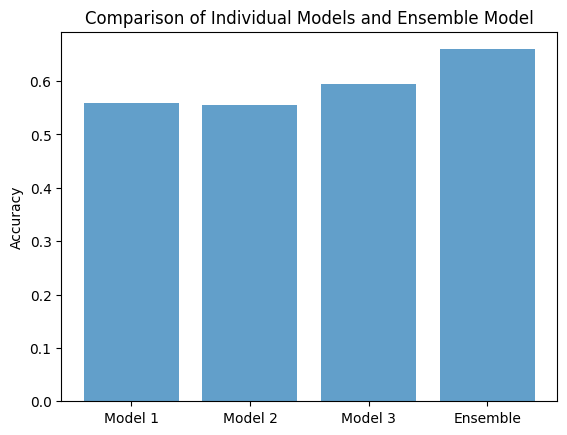

In [37]:
results = sorted(c_results, key=lambda x: x[-1], reverse=True)
c_best = results[0][:5]
print('Best performing classifier model: ', c_best)

scores = []
x_train, x_test, y_train, y_test = train_test_split(cX, cY, train_size=0.8)

model = DT_Classifier(bestC[0], bestC[1], bestC[2])
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
scores.append(get_accuracy(y_test, y_pred))

n, attr = x_train.shape
n, num = y_train.shape
model = LogisticRegression(n, num, attr, lrr, lre)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
scores.append(get_accuracy(y_test, y_pred))

layer = get_nodes(5, 10, x_train, y_train)
model = MLP_Classifier(layer, 'tanh', 0.01, 100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
scores.append(get_accuracy(y_test, y_pred))

en_accuracy = classifier_bagging(c_best[0], c_best[1], c_best[2], c_best[3], c_best[4])
scores.append(en_accuracy)

fig, ax = plt.subplots()
labels = ['Model 1', 'Model 2', 'Model 3', 'Ensemble']
ax.bar(np.arange(len(labels)), scores, align='center', alpha=0.7)
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel('Accuracy')

plt.title('Comparison of Individual Models and Ensemble Model')
plt.show()

In [38]:
r_results = []
for model in r_models:
    for num in n_estimators:
        for frac in fractions:
            for boots in bootstrap:
                for vote in voting:
                    score = regressor_bagging(model, num, frac, boots, vote)
                    r_results.append([model, num, frac, boots, vote, score])

Best performing regressor model:  ['MLPR', 15, 0.5, False, 'hard']


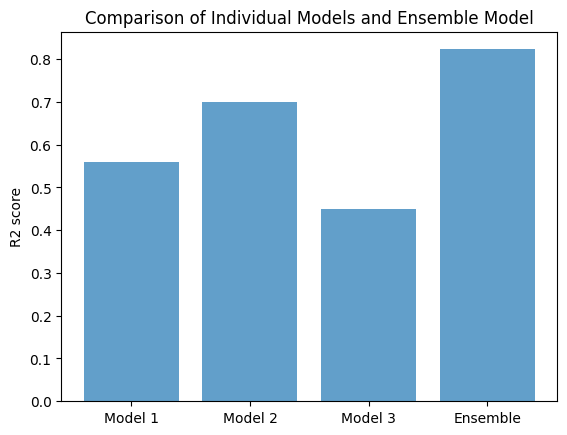

In [106]:
results = sorted(r_results, key=lambda x: x[-1], reverse=True)
r_best = results[0][:5]
print('Best performing regressor model: ', r_best)

scores = []
x_train, x_test, y_train, y_test = train_test_split(rX, rY, train_size=0.8)

model = DT_Regressor(bestR[0], bestR[1], bestR[2])
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
scores.append(r2_score(y_test, y_pred))

model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
scores.append(r2_score(y_test, y_pred))

layer = get_nodes(5, 10, x_train, y_train)
model = MLP_Regressor(layer, 'sigmoid', 0.001, 100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
scores.append(r2_score(y_test, y_pred))

en_score = regressor_bagging(r_best[0], r_best[1], r_best[2], r_best[3], r_best[4])
scores.append(en_score)

fig, ax = plt.subplots()
labels = ['Model 1', 'Model 2', 'Model 3', 'Ensemble']
ax.bar(np.arange(len(labels)), scores, align='center', alpha=0.7)
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel('R2 score')

plt.title('Comparison of Individual Models and Ensemble Model')
plt.show()

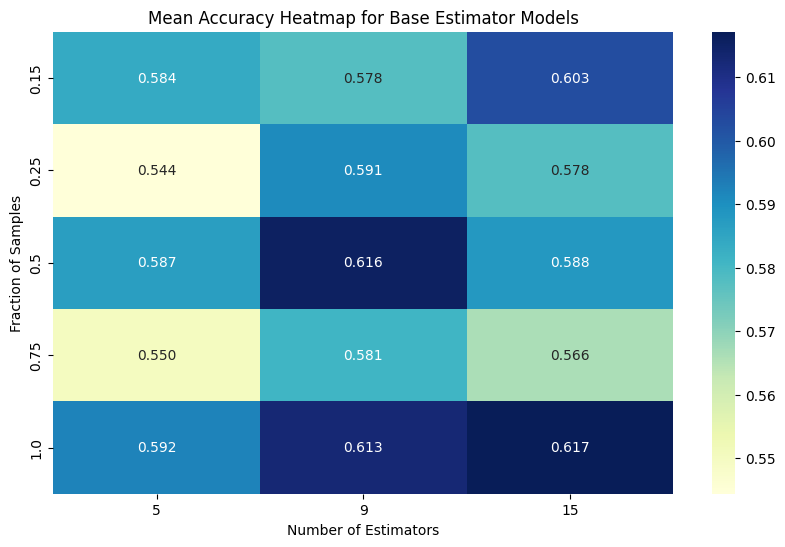

In [63]:
values = np.zeros((len(fractions), len(n_estimators)))
for i, frac in enumerate(fractions):
    for j, num in enumerate(n_estimators):
        accuracies = [classifier_bagging(model, num, frac, True, 'soft') for model in c_models]
        values[i, j] = np.mean(accuracies)

plt.figure(figsize=(10, 6))
sns.heatmap(values, annot=True, fmt=".3f", cmap="YlGnBu", xticklabels=n_estimators, yticklabels=fractions)
plt.xlabel('Number of Estimators')
plt.ylabel('Fraction of Samples')
plt.title('Mean Accuracy Heatmap for Base Estimator Models')
plt.show()

In [100]:
def get_config(num, k, x, y):
    layer = []
    layer.append(x)
    for _ in range(num):
        layer.append(k)
    layer.append(y)
    return layer

def perform_Kfold(classification, model, x_train, y_train, x_test):
    folds = KFold(n_splits=5, shuffle=True)
    X, Y = [], []

    for ti, vi in folds.split(x_train, y_train):
        x_t, y_t = x_train[ti], y_train[ti]
        x_v, y_v = x_train[vi], y_train[vi]
        model.fit(x_t, y_t)
        if classification:
            pred_v = np.argmax(model.predict(x_v), axis=1)
        else: pred_v = model.predict(x_v)
        if len(X) == 0: X = pred_v
        else: X = np.concatenate((X, pred_v))
        if len(Y) == 0: Y = y_v
        else: Y = np.concatenate((Y, y_v))

    if classification:
        y_pred = np.argmax(model.predict(x_test), axis=1)
    else: y_pred = model.predict(x_test)
    return pd.DataFrame(X), Y, pd.DataFrame(y_pred)

def perform_holdout(classification, model, x_train, y_train, x_valid, x_test):
    model.fit(x_train, y_train)
    if classification:
        x = np.argmax(model.predict(x_valid), axis=1)
    else: x = model.predict(x_valid)
    if classification:
        y = np.argmax(model.predict(x_test), axis=1)
    else: y = model.predict(x_test)
    return pd.DataFrame(x), pd.DataFrame(y)
    

In [101]:
def classifier_stacking(method):
    x_train, x_test, y_train, y_test = train_test_split(cX, cY, train_size=0.7)
    model_1 = DT_Classifier(bestC[0], bestC[1], bestC[2])
    model_2 = LogisticRegression(640, 6, 11, lrr, lre)
    model_3 = MLP_Classifier(get_config(5, 10, 11, 6), 'tanh', 0.01, 100)

    if method == 'stacking':
        x_1, trainY, y_1 = perform_Kfold(1, model_1, x_train, y_train, x_test)
        x_2, trainY, y_2 = perform_Kfold(1, model_2, x_train, y_train, x_test)
        x_3, trainY, y_3 = perform_Kfold(1, model_3, x_train, y_train, x_test)
    elif method == 'blending':
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, train_size=0.7)
        x_1, y_1 = perform_holdout(1, model_1, x_train, y_train, x_valid, x_test)
        x_2, y_2 = perform_holdout(1, model_2, x_train, y_train, x_valid, x_test)
        x_3, y_3 = perform_holdout(1, model_3, x_train, y_train, x_valid, x_test)
        trainY = y_valid

    trainX = pd.concat([x_1, x_2, x_3], axis=1)
    testX = pd.concat([y_1, y_2, y_3], axis=1)

    n, attr = trainX.shape
    n, num = trainY.shape
    model = LogisticRegression(n, num, attr, lrr, lre)
    model.fit(trainX, trainY)
    y_pred = model.predict(testX)
    accuracy = get_accuracy(y_test, y_pred)
    return accuracy
    
def regressor_stacking(method):
    x_train, x_test, y_train, y_test = train_test_split(rX, rY, train_size=0.85)
    model_1 = DT_Regressor(bestR[0], bestR[1], bestR[2])
    model_2 = LinearRegression()
    model_3 = MLP_Regressor(get_config(5, 10, 13, 1), 'sigmoid', 0.001, 10)

    if method == 'stacking':
        x_1, trainY, y_1 = perform_Kfold(0, model_1, x_train, y_train, x_test)
        x_2, trainY, y_2 = perform_Kfold(0, model_2, x_train, y_train, x_test)
        x_3, trainY, y_3 = perform_Kfold(0, model_3, x_train, y_train, x_test)
    elif method == 'blending':
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, train_size=0.7)
        x_1, y_1 = perform_holdout(0, model_1, x_train, y_train, x_valid, x_test)
        x_2, y_2 = perform_holdout(0, model_2, x_train, y_train, x_valid, x_test)
        x_3, y_3 = perform_holdout(0, model_3, x_train, y_train, x_valid, x_test)
        trainY = y_valid

    trainX = pd.concat([x_1, x_2, x_3], axis=1)
    testX = pd.concat([y_1, y_2, y_3], axis=1)

    model = LinearRegression()
    model.fit(trainX, trainY)
    y_pred = model.predict(testX)
    score = r2_score(y_test, y_pred)
    return score

In [111]:
ac1 = classifier_stacking('stacking')
ac2 = classifier_stacking('blending')
if ac1 > ac2:
    print('Stacking is best model for classification')
else: 
    print('Blending is best model for classification')

score1 = regressor_stacking('stacking')
score2 = regressor_stacking('blending')
if score1 > score2:
    print('Stacking is best model for regression')
else: 
    print('Blending is best model for regression')

Blending is best model for classification
Blending is best model for regression


In [114]:
ts1 = time.time()
bg_accuracy = classifier_bagging(c_best[0], c_best[1], c_best[2], c_best[3], c_best[4])
te1 = time.time()

ts2 = time.time()
if ac1 > ac2: st_accuracy = classifier_stacking('stacking')
else: st_accuracy = classifier_stacking('blending')
te2 = time.time()

ts3 = time.time()
bg_score = regressor_bagging(r_best[0], r_best[1], r_best[2], r_best[3], r_best[4])
te3 = time.time()

ts4 = time.time()
if score1 > score2: st_score = regressor_stacking('stacking')
else: st_score = regressor_stacking('blending')
te4 = time.time()

print('Classification: ')
print('Bagging -> Accuracy: {:.4f} Time: {:.4f}'.format(bg_accuracy, te1-ts1))
print('Stacking -> Accuracy: {:.4f} Time: {:.4f}'.format(st_accuracy, te2-ts2))
print('\n')
print('Regression: ')
print('Bagging -> Accuracy: {:.4f} Time: {:.4f}'.format(bg_score, te3-ts3))
print('Stacking -> Accuracy: {:.4f} Time: {:.4f}'.format(st_score, te4-ts4))

Classification: 
Bagging -> Accuracy: 0.6070 Time: 0.0296
Stacking -> Accuracy: 0.4257 Time: 0.4108


Regression: 
Bagging -> Accuracy: 0.7286 Time: 37.0812
Stacking -> Accuracy: 0.9002 Time: 0.4268
